In [1]:
import os, librosa

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython import display
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import reciprocal



In [2]:
def onehot(str):
    path = './Drum'
    kits = os.listdir(path)
    #kits.remove('.DS_Store')
    
    oh = []

    for kit in kits:
        if str == kit:
            oh.append(1)
        else:
            oh.append(0)
    
    return np.array(oh)

In [3]:
def make4096(wav):
    while len(wav) < 4096:
        wav = np.append(wav, np.array([0]))
    return wav[:4096]
            

---

In [4]:
#path = 'Drum\Snare\9th Snare 38.wav'

y_label = None
x_label = None

drumkit_path = './Drum'
kits = os.listdir(drumkit_path)
n=0

for kit in kits:
    path = os.path.join(drumkit_path, kit)
    sounds = os.listdir(path)
    
    for sound in sounds:
        wavfile = os.path.join(path, sound)
        y, sr = librosa.load(wavfile)
        yt, index = librosa.effects.trim(y=y, top_db=30)
        y_16k = librosa.resample(yt, orig_sr=sr, target_sr=16000)
        #yt16k = librosa.util.normalize(y_16k)
        n += len(y_16k)
        yt16k = make4096(y_16k)
        yt16k = np.expand_dims(yt16k, axis=0)
        
        typ = onehot(kit)
        typ = np.expand_dims(typ, axis=0)
        
        if x_label is None:
            x_label = yt16k.copy()
            y_label = typ.copy()
        else:
            x_label = np.concatenate((x_label, yt16k), axis=0)
            y_label = np.concatenate((y_label, typ), axis=0)
        
        

In [5]:
n / 700

6285.528571428571

In [6]:


x_train, x_test, y_train, y_test = train_test_split(x_label, y_label, test_size=0.2, random_state=1234, stratify=y_label)

In [7]:
yy_test = np.argmax(y_test, axis = 1)
yy_train = np.argmax(y_train, axis = 1)

---

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4096), dtype=tf.float32,),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(7)
    ])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, yy_train, epochs=20, validation_split=0.2, verbose = 0)

2022-06-01 15:38:18.165872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:38:18.455884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


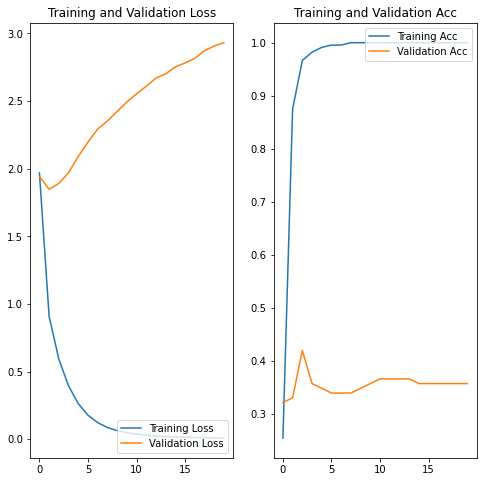

In [19]:


acc = history.history['loss']
val_acc = history.history['val_loss']

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Loss')
plt.plot(epochs_range, val_acc, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Acc')
plt.plot(epochs_range, val_loss, label='Validation Acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Acc')
plt.show()

In [20]:
y_pred =model.predict(x_test)
ypred = np.argmax(y_pred,axis=1)

2022-06-01 15:38:21.465845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [32]:
model.evaluate(x_test,yy_test)

5/5 [==============================] - 0s 19ms/step - loss: 2.5574 - accuracy: 0.3429


[2.5574066638946533, 0.34285715222358704]

<AxesSubplot:>

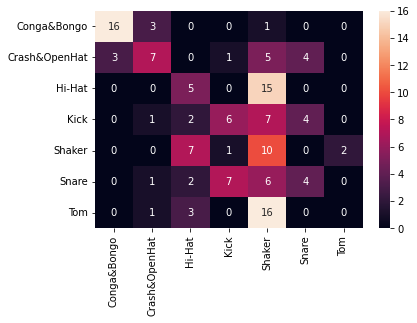

In [ ]:


classes = ['Conga&Bongo', 'Crash&OpenHat', 'Hi-Hat', 'Kick', 'Shaker', 'Snare', 'Tom']

cm = pd.DataFrame(confusion_matrix(yy_test, ypred), columns=classes, index=classes)
sns.heatmap(cm, annot=True)

Making a better Model

In [22]:


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[4096]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(7, activation='softmax'))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [24]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

/var/folders/wn/fhcj6_9d2qb5d0pw_xw20ky80000gn/T/ipykernel_1793/1709004121.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [23]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [25]:

param_distribs = {
"n_hidden": [0, 1, 2, 3],
"n_neurons": np.arange(1, 100).tolist(),
"learning_rate": reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=0)

rnd_search_cv.fit(x_train, yy_train, epochs=1000, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)

2022-06-01 15:38:54.036835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:38:54.403825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 9ms/step - loss: 1.7059 - accuracy: 0.4064


2022-06-01 15:38:58.779758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:38:58.987785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 8ms/step - loss: 1.8432 - accuracy: 0.3369


2022-06-01 15:39:02.658380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:39:02.999565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 8ms/step - loss: 1.7729 - accuracy: 0.3333


2022-06-01 15:39:09.254854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:39:09.531294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 18ms/step - loss: 1.5526 - accuracy: 0.4439


2022-06-01 15:39:20.074782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:39:20.354999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 11ms/step - loss: 1.6686 - accuracy: 0.3743


2022-06-01 15:39:31.644294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:39:31.966691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 12ms/step - loss: 1.4919 - accuracy: 0.4247


2022-06-01 15:39:45.542309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:39:45.908060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 10ms/step - loss: 1.7339 - accuracy: 0.3369


2022-06-01 15:40:47.531562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:40:47.752771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 8ms/step - loss: 1.8329 - accuracy: 0.3209


2022-06-01 15:41:23.561747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:41:23.791477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 9ms/step - loss: 1.7265 - accuracy: 0.3548


2022-06-01 15:42:32.952373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:42:33.881133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 9ms/step - loss: 1.9206 - accuracy: 0.1872


2022-06-01 15:42:53.643932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:42:53.911437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 9ms/step - loss: 1.9524 - accuracy: 0.2032


2022-06-01 15:42:55.082797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:42:55.356987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 11ms/step - loss: 1.9293 - accuracy: 0.2581


2022-06-01 15:43:50.631609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:43:50.833088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 8ms/step - loss: 2.0975 - accuracy: 0.2139


2022-06-01 15:43:52.140291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:43:52.343615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 7ms/step - loss: 2.1575 - accuracy: 0.2460


2022-06-01 15:43:53.322649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:43:53.531493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 8ms/step - loss: 2.1425 - accuracy: 0.2419


2022-06-01 15:43:54.941305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:43:55.270025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 11ms/step - loss: 1.8585 - accuracy: 0.2032


2022-06-01 15:45:18.027286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:45:18.326825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 10ms/step - loss: 1.8562 - accuracy: 0.2727


2022-06-01 15:46:40.956530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:46:41.266578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 11ms/step - loss: 1.8686 - accuracy: 0.2312


2022-06-01 15:48:05.879650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:48:06.107324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 8ms/step - loss: 2.0718 - accuracy: 0.2032


2022-06-01 15:48:07.296712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:48:07.519885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 8ms/step - loss: 2.1245 - accuracy: 0.2353


2022-06-01 15:48:09.261239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:48:09.475443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 9ms/step - loss: 2.1250 - accuracy: 0.2419


2022-06-01 15:48:11.089611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:48:11.350659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 10ms/step - loss: 1.7075 - accuracy: 0.3369


2022-06-01 15:48:19.615545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:48:19.851711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 9ms/step - loss: 1.8254 - accuracy: 0.3369


2022-06-01 15:48:26.922988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:48:27.307725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 11ms/step - loss: 1.7511 - accuracy: 0.3280


2022-06-01 15:48:39.309466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:48:39.586831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 11ms/step - loss: 1.7028 - accuracy: 0.3957


2022-06-01 15:49:56.534769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:49:56.799765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 17ms/step - loss: 1.8717 - accuracy: 0.3209


2022-06-01 15:50:39.501856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:50:39.848320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 16ms/step - loss: 1.7481 - accuracy: 0.3118


2022-06-01 15:51:51.931500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:51:53.074758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 12ms/step - loss: 1.6053 - accuracy: 0.2567


2022-06-01 15:52:05.570364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:52:05.918398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 10ms/step - loss: 1.8149 - accuracy: 0.2246


2022-06-01 15:52:08.740090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:52:09.052919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 13ms/step - loss: 1.7489 - accuracy: 0.2258


2022-06-01 15:52:18.122110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-01 15:52:18.401160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x2d742cbe0>,
                   param_distributions={'learning_rate': [0.005321475226057264,
                                                          0.018687712384057968,
                                                          0.014323219976668883,
                                                          0.0037304282445737706,
                                                          0.01534717506805142,
                                                          0.0009418531195152012,
                                                          0.0008404343021152163,
                                                          0.0019234077478699572,
                                                          0.015542828417132795,
                                                          0.0009079539020525209,...
                                                          0.00085468761

In [26]:
rnd_search_cv.best_params_

{'n_neurons': 89, 'n_hidden': 3, 'learning_rate': 0.009588901343130033}

In [27]:
rnd_search_cv.best_score_

-1.5710324048995972

In [29]:
rndmodel = rnd_search_cv.best_estimator_.model

In [30]:
y_pred =rndmodel.predict(x_test)
ypred = np.argmax(y_pred,axis=1)

2022-06-01 15:54:12.469634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [33]:
rndmodel.evaluate(x_test,yy_test)

5/5 [==============================] - 0s 17ms/step - loss: 1.5271 - accuracy: 0.3929


[1.5270614624023438, 0.3928571343421936]

<AxesSubplot:>

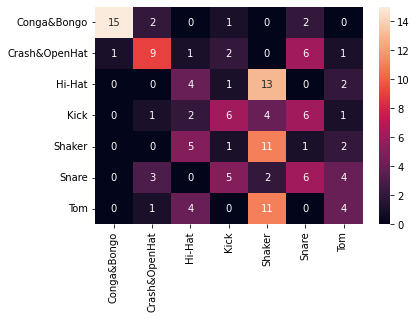

In [34]:
cm = pd.DataFrame(confusion_matrix(yy_test, ypred), columns=classes, index=classes)
sns.heatmap(cm, annot=True)